In [14]:
import copy
import random
import numpy as np
import matplotlib.pyplot as plt
import math

# =================================
# Defining constants
# =================================

# fat
fat_shc = 1.9842e3 # J kg-1 K-1
fat_tc = 1.8071e-1 # W m-1 K-1
fat_density = 9.2559e2 # kg m-3

# protein
protein_shc = 2.0082e3 # J kg-1 K-1
protein_tc = 1.7881e-1 # W m-1 K-1
protein_density = 1.3299e3 # kg m-3

# water
water_shc = 4.184e3 # J kg-1 K-1
water_tc = 6e-1 # W m-1 K-1
water_density = 9.97e2 # kg m-3

# pixel
pixel_side_length = 0.0025 # meter

# temperatures
max_temperature = 220
room_temperature = 25 # celsius
heating_temperature = 200 # celsius
ideal_internal_temperature = 60 # celsius

# temperature thresholds
maillard_temp = 130 # celsius
burnt_temp = 175 # celcius

# composition
fat_percentage = .09
water_percentage = .69
protein_percentage = 1 - fat_percentage - water_percentage

pxl_type = {
        0: "source",
        1: "fat",
        2: "protein",
        3: "water",
        4: "maillard",
        5: "burnt"
    }

colors_dict = {
        "GOLD" : [153/255,101/255,21/255],
        "BLACK": [0,0,0],
        "RED": [255/255,0,0],
        "RAW_COLOR": [230/255,117/255,122/255], # light pink
        "INNER_COOKED_COLOR": [158/255,155/255,147/255], # grey
        "OUTER_COOKED_COLOR": [94/255,65/255,37/255],
        "FAT": [255/255,255/255,255/255],
        "WATER": [0,0,255/255]
    }



In [2]:
def create_pixel(temperature, thermal_conductivity, specific_heat_capacity, density, pxl_type_num,outer):
    return {
        "temp": temperature,
        "tc" : thermal_conductivity,
        "shc": specific_heat_capacity,
        "density": density,
        "type": pxl_type[pxl_type_num],
        "outer": outer
    }

def get_temp(pixel):
    return pixel["temp"]

def get_tc(pixel):
    return pixel["tc"]

def get_shc(pixel):
    return pixel["shc"]

def get_density(pixel):
    return pixel["density"]

def get_type(pixel):
    return pixel["type"]

def get_outer(pixel):
    return pixel["outer"]

def change_temp(pxl, new_temp):
    pxl["temp"] = new_temp

def set_pxl_type(pxl,pxl_type_num):
    pxl["type"] = pxl_type[pxl_type_num]

In [3]:
def create_steak(height, width):
    res = []
    for i in range(height + 1):
        # we define the outer threshold as the 1/8 outer layers of the steak
        outer = True if i < height * 1/8 or i > height * (1 - 1/8) - 1 else False
        tmp = []
        for j in range(width):
            if i < height:
                random_float = random.random()
                if random_float < fat_percentage:
                    tmp.append(create_pixel(room_temperature,fat_tc,fat_shc, fat_density, 1, outer))
                elif fat_percentage <= random_float < fat_percentage + water_percentage:
                    tmp.append(create_pixel(room_temperature,water_tc,water_shc, water_density, 3, outer))
                else:
                    tmp.append(create_pixel(room_temperature,protein_tc,protein_shc, protein_density, 2, outer))
            else:
                tmp.append(create_pixel(heating_temperature,0,0,0,0,False))
        res.append(tmp)
    return res

In [4]:
def step_pixel(image, i=0, j=0, t=0.01):

    # PART 1: GET THE TOP AND BOTTOM PIXEL DATA
    n_rows = np.shape(image)[0]
    n_cols = np.shape(image)[1]

    top = image[i-1,j] if i > 0 else None
    bottom = image[i+1,j] if i < n_rows-1 else None
    left = image[i,j-1] if j > 0 else None
    right = image[i,j+1] if j < n_cols-1 else None

    pixels_in_contact = np.array([x for x in [top,left,right,bottom] if x is not None])
    pixel_of_interest = image[i,j]

    # PART 2: CALCULATE FINAL TEMP OF PIXEL I,J
    temps = np.array(list(get_temp(pixel) for pixel in pixels_in_contact))
    center = get_temp(pixel_of_interest)
    ini_temp_diff = temps - center

    avg_tc_arr = np.zeros(len(pixels_in_contact))
    for idx, pxl in enumerate(pixels_in_contact):
        if get_type(pxl) != "source":
            avg_tc_arr[idx] = (get_tc(pxl) + get_tc(pixel_of_interest))/2
        else:
            avg_tc_arr[idx] = get_tc(pixel_of_interest)
    
    heat_gain = np.sum(t * avg_tc_arr * pixel_side_length * ini_temp_diff)

    vol = pixel_side_length ** 3
    rho = get_density(pixel_of_interest)
    shc = get_shc(pixel_of_interest)
    denom = vol * rho * shc
    change_in_temp = heat_gain / denom
    
    if i == 0 or j == 0 or j == n_cols-1:
        # accounting lost of heat to surroundings
        # final_temp = get_temp(pixel_of_interest) + change_in_temp
        final_temp = get_temp(pixel_of_interest) + change_in_temp - (
                (4 - len(pixels_in_contact)) *
                pixel_side_length *
                get_tc(pixel_of_interest) * 
                (get_temp(pixel_of_interest) - room_temperature) * t
        )
    else:
        final_temp = get_temp(pixel_of_interest) + change_in_temp

    return final_temp.item()


def step(image, timestep=0.01):
    height = len(image)
    width = len(image[0])

    # create a copy so that the kernel refers to old temp values
    image_copy_np = np.array(copy.deepcopy(image))

    for i in range(height):
        for j in range(width):
            pxl = image[i][j]
            if get_type(pxl) != "source":
                step_temperature = step_pixel(image_copy_np, i, j, timestep)
                change_temp(pxl, step_temperature)
                if get_temp(pxl) >= burnt_temp:
                    #set state to burnt
                    set_pxl_type(pxl,5)
                if get_temp(pxl) >= maillard_temp and get_type(pxl) != "burnt":
                    #set state to maillard
                    set_pxl_type(pxl,4)

In [15]:
def to_color(pxl,min_temp = room_temperature, max_temp = max_temperature):

    temp = get_temp(pxl)

    temp = min_temp if temp < min_temp else max_temp if temp > max_temp else temp
    # if temp < min_temp or temp > max_temp:
    #     print(f"Please enter a temperature between {min_temp} and {max_temp}!")
    heat_index = (temp - min_temp)/(max_temp - min_temp)
    # if get_type(pxl) == "maillard":
    #     color = colors_dict["GOLD"]
    # elif get_type(pxl) == "burnt":
    #     color = colors_dict["BLACK"]
    if get_type(pxl) == "source":
        color = colors_dict["RED"]
    else:
        if get_outer(pxl):
            raw_color = colors_dict["RAW_COLOR"]
            cooked_color = colors_dict["OUTER_COOKED_COLOR"]
        else:
            raw_color = colors_dict["RAW_COLOR"]
            cooked_color = colors_dict["INNER_COOKED_COLOR"]
        color = list(map(lambda x : (((cooked_color[x] - raw_color[x]) * heat_index) + raw_color[x]),range(3)))
    return color

def get_color_map(image):
    # image = list(list(get_temp(pixel) for pixel in row) for row in image)
    res = []
    for i in range(len(image)):
        tmp = []
        for j in range(len(image[0])):
            tmp.append(to_color(image[i][j]))
        res.append(tmp)
    return res

In [6]:
def flip(steak):
    heating = steak.pop(-1)
    steak.reverse()
    steak.append(heating)

def plot_heatmaps(image,timestep,interval,total_duration):
    n_plots = total_duration // interval
    i = 0
    arr_of_images = []
    internal_temperature = []
    external_temperature = []
    print("Processing ... ")
    while i < n_plots:
        # print(f"Creating plot no. {i+1} ...")
        j = 0
        while j < (interval / timestep):
            duration = round(timestep * j + i * interval,2)
            # print(f"t = {duration} seconds")
            #flip steak every 30 seconds
            if duration % 30 == 0:
                # print(f"I printed the steak at {timestep * j + i * interval} seconds")
                flip(image)

            internal_temp = get_temp(image[len(image)//2][len(image[0])//2])
            internal_temperature.append(internal_temp)


            upper_temp = list(map(lambda x : get_temp(x),image[0]))
            lower_temp = list(map(lambda x : get_temp(x),image[-2]))
            average_upper_temp = sum(upper_temp)/len(upper_temp)
            average_lower_temp = sum(lower_temp)/len(lower_temp)
            external_temp = (average_upper_temp + average_lower_temp)/2
            

            external_temperature.append(external_temp)
            
            step(image,timestep)            

            # plt.imshow(get_color_map(image))
            # plt.axis('off')
            # plt.savefig(f'./images/image_t_{duration}.jpg',dpi=300, bbox_inches='tight', pad_inches=0.5)
            # plt.close()
            
            j += 1
        # print(f"Plot no. {i+1} created")
        arr_of_images.append(copy.deepcopy(image))
        i += 1
    print("Done")
    return (arr_of_images, internal_temperature, external_temperature)

In [9]:
image = create_steak(16,30)
arr, internal_temp, external_temp = plot_heatmaps(image,0.1,2.5,1000)
# plt.imshow(get_color_map(image))

Processing ... 
Done


In [17]:
len(arr)

400

In [19]:
filtered_arr = list(map(lambda x : arr[x],list(filter(lambda x : x%100 == 0,range(len(arr))))))
len(filtered_arr)

4

In [23]:
list(filter(lambda x : x%100 == 0,range(len(arr))))

[0, 100, 200, 300]

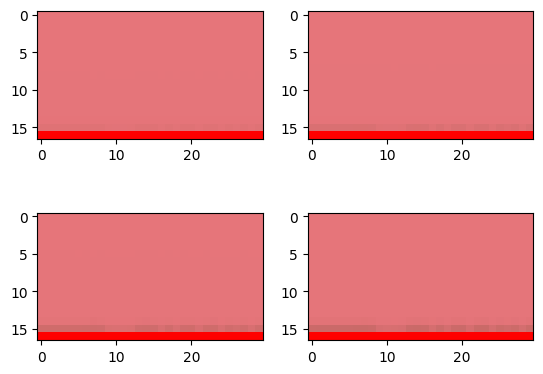

In [21]:
fig, ax = plt.subplots(2,2)
for i in range(len(ax)):
    for j in range(len(ax[0])):
        ax[i,j].imshow(get_color_map(arr[i * 3 + j]))
plt.show()

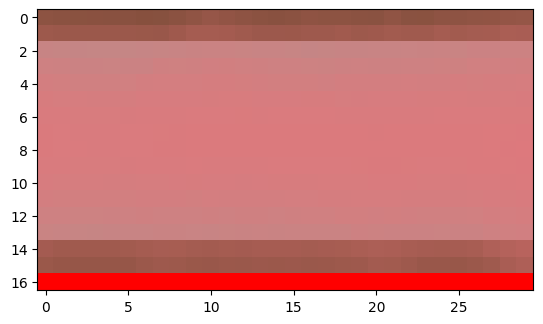

In [24]:
plt.imshow(get_color_map(arr[300]))

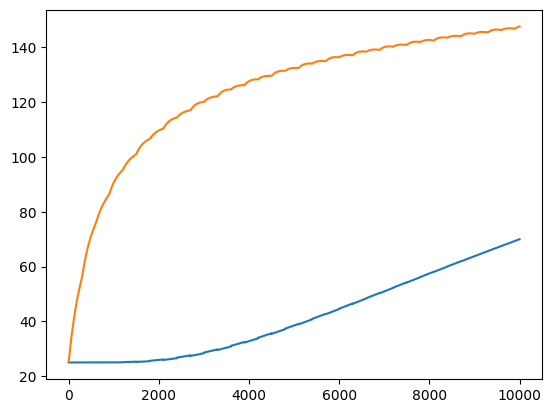

In [10]:
plt.plot(internal_temp)
plt.plot(external_temp)
plt.show()

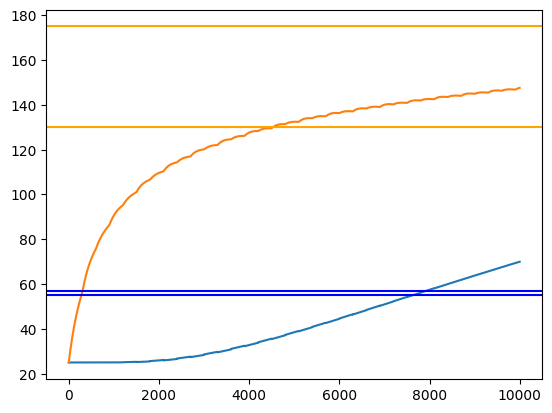

In [11]:
plt.plot(internal_temp)
plt.plot(external_temp)
plt.axhline(55,color="blue")
plt.axhline(57,color="blue")
plt.axhline(130,color="orange")
plt.axhline(175,color="orange")
plt.show()

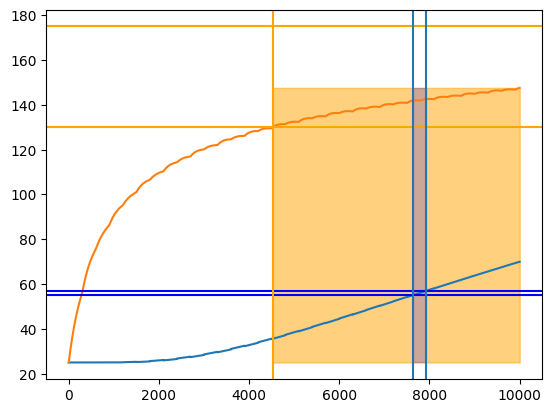

In [28]:
plt.plot(internal_temp)
plt.plot(external_temp)
plt.axhline(55,color="blue")
plt.axhline(57,color="blue")
plt.axhline(130,color="orange")
plt.axhline(175,color="orange")
plt.axvline(external_temp.index(min(external_temp, key=lambda x:abs(x-130))),color="orange")
plt.axvline(internal_temp.index(min(internal_temp, key=lambda x:abs(x-55))))
plt.axvline(internal_temp.index(min(internal_temp, key=lambda x:abs(x-57))))
plt.fill_between(range(external_temp.index(min(external_temp, key=lambda x:abs(x-130))),len(external_temp)+1),min(external_temp),max(external_temp),color="orange",alpha=.5)
plt.fill_between(range(internal_temp.index(min(internal_temp, key=lambda x:abs(x-55))),internal_temp.index(min(internal_temp, key=lambda x:abs(x-57)))),min(external_temp),max(external_temp),color="blue",alpha=.2)

plt.savefig('demo.png')
plt.show()

In [ ]:
def to_comp_color(pxl):

    if get_type(pxl) == "source":
        color = colors_dict["RED"]
    elif get_type(pxl) == "fat":
        color = colors_dict["FAT"]
    elif get_type(pxl) == "water":
        color = colors_dict["WATER"]
    elif get_type(pxl) == "protein":
        color = colors_dict["RED"]
    return color

def get_comp_color_map(image):
    res = []
    for i in range(len(image)):
        tmp = []
        for j in range(len(image[0])):
            tmp.append(to_comp_color(image[i][j]))
        res.append(tmp)
    return res

In [ ]:
plt.imshow(get_comp_color_map(arr[0]))